# Self-Consistency

This notebook illustrates the key idea from the paper [Self-Consistency Improves Chain of Thought Reasoning in Language Models](https://arxiv.org/pdf/2203.11171) (Wang et al., 2023), which, as the title suggests, is how self-consistency decoding improves accuracy in reasoning tasks over regular chain-of-thought prompting with greedy decoding.

Additionally, we compare one-shot self-consistency with few-shot chain-of-thought as an original experiment.

## Installing dependencies and setting up the API calls

In [33]:
!pip install datasets

In [34]:
import concurrent.futures
import random
import requests
import time
import matplotlib.pyplot as plt
import datasets
from collections import defaultdict
from tqdm import tqdm

# Your Hugging Face API token
API_TOKEN = ""

# Specify the model ID
MODEL_ID = "bigscience/bloom"

# API endpoint
API_URL = f"https://api-inference.huggingface.co/models/{MODEL_ID}"

# Headers for authentication
headers = {"Authorization": f"Bearer {API_TOKEN}"}

## Functions for Decoding

In [35]:
RETRIES = 5
TIMEOUT = 10

def greedy_decode(prompt):
    input = {
        "inputs": prompt,
        "parameters": {
            "max_new_tokens": 500,
            "temperature": 0.01, # temperature 0 is not allowed, so just set to a small value
            "seed": random.randint(0, 2**32 - 1),
            "stop": ["\nQ:"], # don't let model generate new questions
        }
    }

    retries = 0
    response = None
    while retries < RETRIES and response is None:
        response = requests.post(API_URL, headers=headers, json=input)

        if response.status_code == 200:
            return response.json()[0]["generated_text"].removesuffix("\nQ:")
        else:
            retries += 1
            print(f"Error {response.status_code}: {response.text}")
            time.sleep(TIMEOUT)


def sampled_decode(prompt):
    input = {
        "inputs": prompt,
        "parameters": {
            "max_new_tokens": 500,
            "temperature": 0.8,
            "top_k": 40,
            "top_p": 0.95,
            "seed": random.randint(0, 2**32 - 1),
            "stop": ["\nQ:"], # don't let model generate new questions
        }
    }

    retries = 0
    response = None

    while retries < RETRIES and response is None:
        response = requests.post(API_URL, headers=headers, json=input)

        if response.status_code == 200:
            return response.json()[0]["generated_text"].removesuffix("\nQ:")
        else:
            retries += 1
            print(f"Error {response.status_code}: {response.text}")
            time.sleep(TIMEOUT)


def self_consistency_decode(prompt, n_paths, parallelize=False):
    answers = []
    cutoff = len(prompt)

    if parallelize:
        with concurrent.futures.ThreadPoolExecutor() as executor:
            futures = [executor.submit(sampled_decode, prompt) for _ in range(n_paths)]
            for future in concurrent.futures.as_completed(futures):
                response = future.result()
                answer = extract_answer(response[cutoff:])
                answers.append(answer)
    else:
        for _ in range(n_paths):
            response = sampled_decode(prompt)
            answer = extract_answer(response[cutoff:])
            answers.append(answer)

    return answers


def extract_answer(answer):
    if "(a" in answer:
        return "A"
    if "(b" in answer:
        return "B"
    if "(c" in answer:
        return "C"
    if "(d" in answer:
        return "D"
    if "(e" in answer:
        return "E"


def marginalize_answer_counts(answers):
    answer_counts = defaultdict(int)
    for answer in answers:
        if answer is not None:
            answer_counts[answer] += 1
    final_answer = max(answer_counts, key=answer_counts.get)
    return final_answer

## Setting up Datasets

We take examples from the CSQA (Common Sense QA) dataset to run our demonstrative toy experiments.

We use the validation split as in the original paper, and enforce the answer format via exemplars.

In [36]:
CoT_prompts = [
    "Task: Answer the multiple choice question by first thinking through the question and then concluding with 'So the answer is x' where x is one of (a) (b) (c) (d) or (e)",
    "Q: What do people use to absorb extra ink from a fountain pen? Answer Choices: (a) shirt pocket (b) calligrapher’s hand (c) inkwell (d) desk drawer (e) blotter\nA: The answer must be an item that can absorb ink. Of the above choices, only blotters are used to absorb ink. So the answer is (e).",
    "Q: What home entertainment equipment requires cable? Answer Choices: (a) radio shack (b) substation (c) television (d) cabinet\nA: The answer must require cable. Of the above choices, only television requires cable. So the answer is (c).",
    "Q: The fox walked from the city into the forest, what was it looking for? Answer Choices: (a) pretty flowers (b) hen house (c) natural habitat (d) storybook\nA: The answer must be something in the forest. Of the above choices, only natural habitat is in the forest. So the answer is (b).",
]
CoT_prompt = "\n".join(CoT_prompts)

In [37]:
dataset = datasets.load_dataset("tau/commonsense_qa")['validation']

In [38]:
questions = []
answers = []

for i in range(100):
  template = "Q: [question] Answer Choices: (a) [choice_A] (b) [choice_B] (c) [choice_C] (d) [choice_D] (e) [choice_E]"
  question = template.replace("[question]", dataset['question'][i]).replace("[choice_A]", dataset['choices'][i]['text'][0]).replace("[choice_B]", dataset['choices'][i]['text'][1]).replace("[choice_C]", dataset['choices'][i]['text'][2]).replace("[choice_D]", dataset['choices'][i]['text'][3]).replace("[choice_E]", dataset['choices'][i]['text'][4])
  questions.append(question)
  answers.append(dataset['answerKey'][i])

In [39]:
print(questions[0])
print(answers[0])

Q: A revolving door is convenient for two direction travel, but it also serves as a security measure at a what? Answer Choices: (a) bank (b) library (c) department store (d) mall (e) new york
A


### Greedy / sampled decoding demo

In [40]:
prompt = CoT_prompt + "\n" + questions[0] + "\nA: "
cutoff = len(prompt) # the original prompt is prepended to the response, so only extract the newly generated portion

In [41]:
prompt

"Task: Answer the multiple choice question by first thinking through the question and then concluding with 'So the answer is x' where x is one of (a) (b) (c) (d) or (e)\nQ: What do people use to absorb extra ink from a fountain pen? Answer Choices: (a) shirt pocket (b) calligrapher’s hand (c) inkwell (d) desk drawer (e) blotter\nA: The answer must be an item that can absorb ink. Of the above choices, only blotters are used to absorb ink. So the answer is (e).\nQ: What home entertainment equipment requires cable? Answer Choices: (a) radio shack (b) substation (c) television (d) cabinet\nA: The answer must require cable. Of the above choices, only television requires cable. So the answer is (c).\nQ: The fox walked from the city into the forest, what was it looking for? Answer Choices: (a) pretty flowers (b) hen house (c) natural habitat (d) storybook\nA: The answer must be something in the forest. Of the above choices, only natural habitat is in the forest. So the answer is (b).\nQ: A re

Greedy

In [42]:
greedy_result = greedy_decode(prompt)
print(greedy_result[cutoff:])

 The answer must be a building. Of the above choices, only a bank has a revolving door. So the answer is (a).


In [43]:
extract_answer(greedy_result[cutoff:])

'A'

Sampled

In [44]:
sampled_result = sampled_decode(prompt)
print(sampled_result[cutoff:])

 The answer must be a building that serves people. Of the above choices, only library serves people. So the answer is (b).


In [45]:
extract_answer(sampled_result[cutoff:])

'B'

## Running our experiments

In [46]:
max_reasoning_paths = 40
self_consistency_answers = []
greedy_answers = []

for question in tqdm(questions):
    prompt = CoT_prompt + "\n" + question + "\nA: "
    cutoff = len(prompt)

    while True:
        try:
            greedy_result = greedy_decode(prompt)
            greedy_answers.append(extract_answer(greedy_result[cutoff:]))
            break
        except TypeError:
            time.sleep(30)

    while True:
        try:
            self_consistency_result = self_consistency_decode(prompt, max_reasoning_paths, parallelize=True)
            self_consistency_answers.append(self_consistency_result)
            break
        except TypeError:
            time.sleep(30)
    time.sleep(random.randint(0,3))


 36%|███▌      | 36/100 [15:01<27:17, 25.59s/it]

Error 503: {"error":"Service Unavailable"}


 58%|█████▊    | 58/100 [25:47<18:49, 26.89s/it]

Error 503: {"error":"Service Unavailable"}


 75%|███████▌  | 75/100 [33:48<10:21, 24.86s/it]

Error 502: <html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
</body>
</html>



 85%|████████▌ | 85/100 [38:51<06:26, 25.75s/it]

Error 503: {"error":"Service Unavailable"}


100%|██████████| 100/100 [45:39<00:00, 27.40s/it]


In [47]:
num_reasoning_paths = list(range(5, 45, 5))
self_consistency_accuracies = []
greedy_accuracy = sum(greedy_answers[i] == answers[i] for i in range(len(greedy_answers))) / len(greedy_answers)
# self-consistency using various number of reasoning paths
for n in num_reasoning_paths:
    self_consistency_final_answers = [marginalize_answer_counts(answers_list[:n]) for answers_list in self_consistency_answers]
    print(self_consistency_final_answers)
    accuracy = sum(self_consistency_final_answers[i] == answers[i] for i in range(len(self_consistency_final_answers))) / len(self_consistency_final_answers)
    self_consistency_accuracies.append(accuracy)

['A', 'E', 'C', 'E', 'B', 'C', 'B', 'D', 'C', 'E', 'C', 'D', 'B', 'E', 'B', 'C', 'E', 'E', 'C', 'E', 'C', 'C', 'B', 'B', 'E', 'E', 'B', 'C', 'C', 'B', 'C', 'A', 'C', 'D', 'E', 'C', 'E', 'E', 'D', 'B', 'B', 'D', 'E', 'E', 'D', 'E', 'E', 'E', 'E', 'C', 'D', 'C', 'E', 'C', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'B', 'D', 'E', 'D', 'E', 'E', 'E', 'D', 'B', 'E', 'E', 'A', 'E', 'B', 'B', 'C', 'E', 'D', 'B', 'C', 'E', 'B', 'E', 'B', 'C', 'E', 'E', 'C', 'E', 'D', 'D', 'E', 'C', 'D', 'E', 'E', 'E', 'C']
['A', 'E', 'B', 'E', 'E', 'C', 'B', 'D', 'C', 'E', 'B', 'D', 'B', 'E', 'C', 'D', 'E', 'A', 'C', 'E', 'E', 'C', 'E', 'C', 'E', 'E', 'B', 'C', 'D', 'C', 'C', 'B', 'E', 'D', 'E', 'E', 'E', 'E', 'E', 'B', 'B', 'D', 'E', 'E', 'D', 'E', 'E', 'E', 'E', 'C', 'D', 'B', 'E', 'E', 'E', 'E', 'B', 'E', 'D', 'E', 'C', 'E', 'B', 'D', 'E', 'E', 'E', 'C', 'E', 'D', 'E', 'C', 'E', 'A', 'C', 'B', 'B', 'D', 'E', 'D', 'B', 'D', 'E', 'A', 'E', 'B', 'E', 'E', 'E', 'C', 'E', 'D', 'D', 'E', 'C', 'D', 'E', 'C', 'E', 'C'

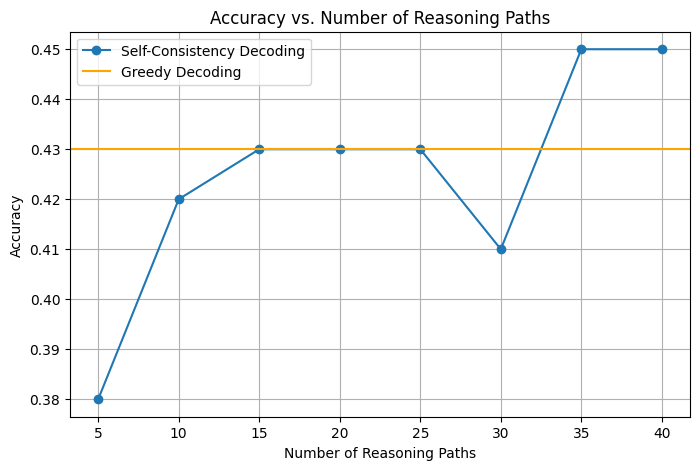

In [48]:
plt.figure(figsize=(8, 5))
plt.plot(num_reasoning_paths, self_consistency_accuracies, marker='o', linestyle='-', label="Self-Consistency Decoding")
plt.axhline(y=greedy_accuracy, color='orange', linestyle='-', label="Greedy Decoding")

# Labels and title
plt.xlabel("Number of Reasoning Paths")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Reasoning Paths")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

## One-shot self-consistency vs. few-shot CoT

We compare the performance of one-shot self-consistency versus few-shot CoT.

The main motivation for this experiment is to determine whether self-consistency can compensate for the absence of a few exemplars. Removing a few exemplars, thus shortening the prompt length, can be particularly useful for self-consistency, as self-consistency involves running the same prompt multiple times. This is especially relevant in our setup, as we use the Hugging Face serverless inference API, which, unlike OpenAI's API, does not support [prompt caching](https://platform.openai.com/docs/guides/prompt-caching).

In [ ]:
CoT_prompts = [
    "Task: Answer the multiple choice question by first thinking through the question and then concluding with 'So the answer is x' where x is one of (a) (b) (c) (d) or (e)",
    "Q: What do people use to absorb extra ink from a fountain pen? Answer Choices: (a) shirt pocket (b) calligrapher’s hand (c) inkwell (d) desk drawer (e) blotter\nA: The answer must be an item that can absorb ink. Of the above choices, only blotters are used to absorb ink. So the answer is (e).",
    "Q: What home entertainment equipment requires cable? Answer Choices: (a) radio shack (b) substation (c) television (d) cabinet\nA: The answer must require cable. Of the above choices, only television requires cable. So the answer is (c).",
    "Q: The fox walked from the city into the forest, what was it looking for? Answer Choices: (a) pretty flowers (b) hen house (c) natural habitat (d) storybook\nA: The answer must be something in the forest. Of the above choices, only natural habitat is in the forest. So the answer is (b).",
]
CoT_instruction = "\n".join(CoT_prompts)
self_consistency_instruction = "\n".join(CoT_prompts[:2]) # only take the first exemplar

In [ ]:
max_reasoning_paths = 40
self_consistency_answers = []
greedy_answers = []

for question in tqdm(questions):
    question_suffix = "\n" + question + "\nA: "
    CoT_prompt = CoT_instruction + question_suffix
    self_consistency_prompt = self_consistency_instruction + question_suffix

    while True:
        try:
            greedy_result = greedy_decode(CoT_prompt)
            greedy_answers.append(extract_answer(greedy_result[len(CoT_prompt):]))
            break
        except TypeError:
            time.sleep(30)

    while True:
        try:
            self_consistency_result = self_consistency_decode(self_consistency_prompt, max_reasoning_paths, parallelize=True)
            self_consistency_answers.append(self_consistency_result)
            break
        except TypeError:
            time.sleep(30)

    time.sleep(random.randint(0,3)) # some delay between requests

  0%|          | 0/100 [00:00<?, ?it/s]

Error 503: {"error":"Service Unavailable"}


 13%|█▎        | 13/100 [07:57<46:48, 32.28s/it]

Error 503: {"error":"Service Unavailable"}


 33%|███▎      | 33/100 [19:44<37:31, 33.60s/it]

Error 502: <html>
<head><title>502 Bad Gateway</title></head>
<body>
<center><h1>502 Bad Gateway</h1></center>
</body>
</html>



 75%|███████▌  | 75/100 [42:16<12:35, 30.23s/it]

Error 503: {"error":"Service Unavailable"}


 97%|█████████▋| 97/100 [54:41<01:28, 29.38s/it]

Error 503: {"error":"Service Unavailable"}


100%|██████████| 100/100 [57:14<00:00, 34.35s/it]


In [ ]:
num_reasoning_paths = list(range(5, 45, 5))
self_consistency_accuracies = []
greedy_accuracy = sum(greedy_answers[i] == answers[i] for i in range(len(greedy_answers))) / len(greedy_answers)
# self-consistency using various number of reasoning paths
for n in num_reasoning_paths:
    self_consistency_final_answers = [marginalize_answer_counts(answers_list[:n]) for answers_list in self_consistency_answers]
    print(self_consistency_final_answers)
    accuracy = sum(self_consistency_final_answers[i] == answers[i] for i in range(len(self_consistency_final_answers))) / len(self_consistency_final_answers)
    self_consistency_accuracies.append(accuracy)

['A', 'A', 'E', 'E', 'E', 'D', 'B', 'D', 'D', 'A', 'E', 'E', 'B', 'E', 'E', 'D', 'E', 'E', 'B', 'E', 'C', 'C', 'D', 'E', 'E', 'D', 'B', 'D', 'B', 'C', 'A', 'A', 'E', 'D', 'E', 'D', 'D', 'E', 'E', 'D', 'B', 'B', 'E', 'E', 'D', 'E', 'E', 'E', 'E', 'C', 'E', 'E', 'C', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'E', 'D', 'C', 'D', 'A', 'A', 'E', 'E', 'A', 'D', 'B', 'B', 'E', 'E', 'C', 'A', 'C', 'E', 'B', 'D', 'D', 'C', 'E', 'E', 'E', 'E', 'C', 'D', 'A', 'C', 'E', 'C', 'E', 'E', 'B', 'E', 'E', 'B', 'E', 'E']
['A', 'A', 'B', 'E', 'E', 'D', 'B', 'D', 'A', 'E', 'B', 'E', 'D', 'E', 'E', 'C', 'E', 'E', 'B', 'E', 'E', 'C', 'D', 'E', 'E', 'D', 'E', 'D', 'B', 'D', 'A', 'A', 'E', 'D', 'E', 'D', 'D', 'E', 'E', 'D', 'B', 'D', 'E', 'E', 'D', 'E', 'E', 'E', 'E', 'C', 'E', 'E', 'E', 'E', 'E', 'E', 'B', 'E', 'E', 'E', 'E', 'E', 'E', 'D', 'A', 'A', 'E', 'E', 'A', 'D', 'B', 'B', 'E', 'C', 'E', 'D', 'B', 'E', 'B', 'A', 'B', 'C', 'E', 'A', 'E', 'C', 'C', 'A', 'E', 'E', 'E', 'B', 'D', 'E', 'B', 'E', 'E', 'B', 'E', 'E'

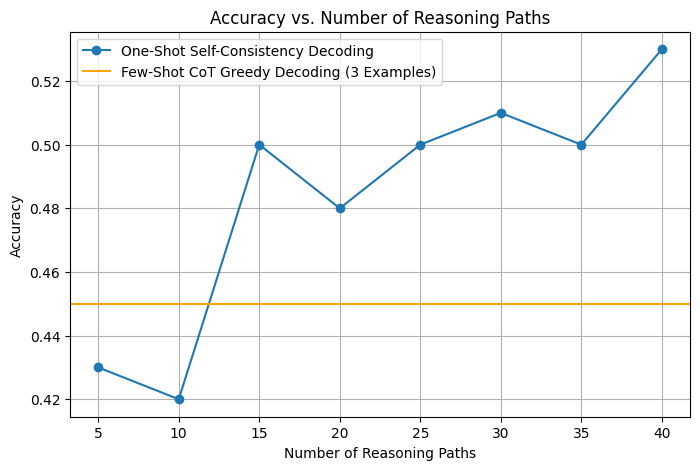

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(num_reasoning_paths, self_consistency_accuracies, marker='o', linestyle='-', label="One-Shot Self-Consistency Decoding")
plt.axhline(y=greedy_accuracy, color='orange', linestyle='-', label="Few-Shot CoT Greedy Decoding (3 Examples)")

# Labels and title
plt.xlabel("Number of Reasoning Paths")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Reasoning Paths")
plt.legend()
plt.grid(True)

# Show the plot
plt.show()